## Training A Basic Sentiment Analysis Network

In [12]:
import tensorflow as tf
tf.enable_eager_execution()
import re
import numpy as np
import time
import pickle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Overview of Data

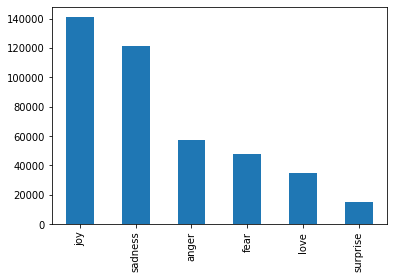

In [13]:
data = pickle.load(open("SentimentRNN/merged_training.pkl", 'rb'))
data.emotions.value_counts().plot.bar()

In [14]:
data.head()

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


### Preprocessing

In [15]:
# retain only text that contain less that 70 tokens to avoid too much padding
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 70].copy()

# sampling
data = data.sample(n=50000, random_state=1);

In [16]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word
            
# construct vocab
inputs = ConstructVocab(data["text"].values.tolist())
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [17]:
# Save this encoder for use later
TEXT_ENCODER_PATH = './SentimentRNN/textEncoder.pkl'

with open(TEXT_ENCODER_PATH, 'wb') as encoderPath:
    pickle.dump(inputs, encoderPath)

In [18]:
# pad data
def max_length(tensor):
    return max(len(t) for t in tensor)

max_length_inp = max_length(input_tensor)
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                             maxlen=max_length_inp,
                                                             padding='post')

In [19]:
### convert targets to one-hot encoding vectors
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)

# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

# eval dicts
get_emotion = lambda t: np.argmax(t)
emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

# ie.
emotion_dict[get_emotion(target_tensor[0])]

'anger'

### Training

In [20]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(40000, 40000, 5000, 5000, 5000, 5000)

In [21]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
print(vocab_inp_size)
target_size = num_emotions

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, 
                                                    target_tensor_train)).shuffle(TRAIN_BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, 
                                                  target_tensor_val)).shuffle(VAL_BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_test, 
                                                    target_tensor_test)).shuffle(TEST_BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

# checking minibatch
print(train_dataset)
print(val_dataset)
print(test_dataset)

27511
<DatasetV1Adapter shapes: ((64, 68), (64, 6)), types: (tf.int32, tf.int32)>
<DatasetV1Adapter shapes: ((64, 68), (64, 6)), types: (tf.int32, tf.int32)>
<DatasetV1Adapter shapes: ((64, 68), (64, 6)), types: (tf.int32, tf.int32)>


In [22]:
### define the GRU component
def gru(units):
    if tf.test.is_gpu_available():
        return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='relu', 
                               recurrent_initializer='glorot_uniform')

### Build the model
class EmoGRU(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        
        # layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.gru = gru(self.hidden_units)
        self.fc = tf.keras.layers.Dense(output_size)
        
    def call(self, x, hidden):
        x = self.embedding(x) # batch_size X max_len X embedding_dim
        output, state = self.gru(x, initial_state = hidden) #  batch_size X max_len X hidden_units
        out = output[:,-1,:]
        out = self.dropout(out)
        out = self.fc(out) # batch_size X max_len X output_size
        return out, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.hidden_units))

In [23]:
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)

# initialize the hidden state of the RNN
hidden = model.initialize_hidden_state()

# testing for the first batch only then break the for loop
# Potential bug: out is not randomized enough
for (batch, (inp, targ)) in enumerate(train_dataset):
    out, state = model(inp, hidden)
    print(out.shape) 
    break
    
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
(64, 6)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  7042816   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
cu_dnngru (CuDNNGRU)         multiple                  3938304   
_________________________________________________________________
dense (Dense)                multiple                  6150      
Total params: 10,987,270
Trainable params: 10,987,270
Non-trainable params: 0
_________________________________________________________________


In [24]:
optimizer = tf.train.AdamOptimizer()

def loss_function(y, prediction):
    return tf.losses.softmax_cross_entropy(y, logits=prediction)

def accuracy(y, yhat):
    #compare the predictions to the truth
    yhat = tf.argmax(yhat, 1).numpy()
    y    = tf.argmax(y   , 1).numpy()
    return np.sum(y == yhat)/len(y)

In [25]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    hidden = model.initialize_hidden_state()
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ)) in enumerate(train_dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            predictions,_ = model(inp, hidden)
            loss += loss_function(targ, predictions)
        batch_loss = (loss / int(targ.shape[1]))        
        total_loss += batch_loss
        
        batch_accuracy = accuracy(targ, predictions)
        train_accuracy += batch_accuracy
        
        gradients = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(zip(gradients, model.variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
            
    ### Validating
    hidden = model.initialize_hidden_state()

    for (batch, (inp, targ)) in enumerate(val_dataset):        
        predictions,_ = model(inp, hidden)        
        batch_accuracy = accuracy(targ, predictions)
        val_accuracy += batch_accuracy
    
    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             total_loss / TRAIN_N_BATCH, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Instructions for updating:
Use tf.cast instead.
Epoch 1 Batch 0 Val. Loss 0.2991
Epoch 1 Batch 100 Val. Loss 0.2490
Epoch 1 Batch 200 Val. Loss 0.2654
Epoch 1 Batch 300 Val. Loss 0.2692
Epoch 1 Batch 400 Val. Loss 0.2636
Epoch 1 Batch 500 Val. Loss 0.2585
Epoch 1 Batch 600 Val. Loss 0.2200
Epoch 1 Loss 0.2638 -- Train Acc. 0.3315 -- Val Acc. 0.2937
Time taken for 1 epoch 93.34416127204895 sec

Epoch 2 Batch 0 Val. Loss 0.2644
Epoch 2 Batch 100 Val. Loss 0.2584
Epoch 2 Batch 200 Val. Loss 0.2385
Epoch 2 Batch 300 Val. Loss 0.2429
Epoch 2 Batch 400 Val. Loss 0.2312
Epoch 2 Batch 500 Val. Loss 0.2283
Epoch 2 Batch 600 Val. Loss 0.2231
Epoch 2 Loss 0.2481 -- Train Acc. 0.4124 -- Val Acc. 0.5409
Time taken for 1 epoch 81.85736632347107 sec

Epoch 3 Batch 0 Val. Loss 0.2529
Epoch 3 Batch 100 Val. Loss 0.1848
Epoch 3 Batch 200 Val. Loss 0.2100
Epoch 3 Batch 300 Val. Loss 0.1869
Epoch 3 Batch 400 Val. Loss 0.1646
Epoch 3 Batch 500 Val. Loss 0.2028
Epoch 3 Batch 600 Val. Loss 0.1520
Epoch 3 Los

In [26]:
# Evaluate on testing data
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

# need fresh model hidden state only per batch???
hidden = model.initialize_hidden_state()

for (batch, (inp, targ)) in enumerate(test_dataset):
    predictions,_ = model(inp, hidden)
    batch_accuracy = accuracy(targ, predictions)
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy/TEST_N_BATCH)

Test Accuracy:  0.8137019230769231


In [27]:
# Save model for usage
model.save_weights('SentimentRNN/checkpoints/')

Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
